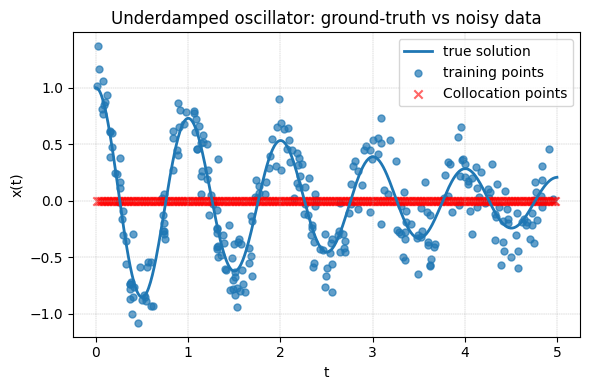

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 300

data_noise = 0.2
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(x_colloc_num, data_noise)


# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [2]:
# UQ Model
from utils_uqmd.utils_uq_distance import DistanceUQPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[64, 128, 265, 265, 128, 64],
    "output_dim":1,
}

uqmodel = DistanceUQPINN(**model_args)
alpha = 0.05
raw_heuristic = "latent"

# Fit the data
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=30000,
    λ_pde= 3.0, λ_ic=10.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
print(f"\n[🟠] Training...")
baseline_loss_dict = uqmodel.fit(**fit_args, **fit_kwargs_grid)

# Model Inferencing
baseline_pred_kwargs = dict(n_samples=200, heuristic_u=raw_heuristic)
print(f"\n[🟠] Base Model Inferencing...")
cp_uncal_predset = uqmodel.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


[🟠] Training...
ep     1 | L=1.09e+01 | lr=1.0e-03
ep   500 | L=9.79e+00 | lr=1.0e-03
ep  1000 | L=9.30e+00 | lr=1.0e-03
ep  1500 | L=8.65e+00 | lr=1.0e-03
ep  2000 | L=9.07e+00 | lr=1.0e-03
ep  2500 | L=1.02e+01 | lr=1.0e-03
ep  3000 | L=9.33e+00 | lr=1.0e-03
ep  3500 | L=8.29e+00 | lr=1.0e-03
ep  4000 | L=9.79e+00 | lr=1.0e-03
ep  4500 | L=7.37e+00 | lr=1.0e-03
ep  5000 | L=8.33e+00 | lr=1.0e-03
ep  5500 | L=7.48e+00 | lr=5.0e-04
ep  6000 | L=7.19e+00 | lr=5.0e-04
ep  6500 | L=7.07e+00 | lr=5.0e-04
ep  7000 | L=7.04e+00 | lr=5.0e-04
ep  7500 | L=7.02e+00 | lr=5.0e-04
ep  8000 | L=6.99e+00 | lr=5.0e-04
ep  8500 | L=6.96e+00 | lr=5.0e-04
ep  9000 | L=6.91e+00 | lr=5.0e-04
ep  9500 | L=6.85e+00 | lr=5.0e-04
ep 10000 | L=6.85e+00 | lr=5.0e-04
ep 10500 | L=6.11e+00 | lr=2.5e-04
ep 11000 | L=5.70e+00 | lr=2.5e-04
ep 11500 | L=5.14e+00 | lr=2.5e-04
ep 12000 | L=4.42e+00 | lr=2.5e-04
ep 12500 | L=2.97e+00 | lr=2.5e-04
ep 13000 | L=2.26e+00 | lr=2.5e-04
ep 13500 | L=2.08e+00 | lr=2.5e-04
ep 

In [ ]:
raw_heuristic="feature"
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP, adaptive_cp_test_uncertainties_grid
adap_cp = AdaptiveCP(uqmodel, alpha=alpha)
cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, k=20,
    heuristic_u=raw_heuristic
)


[🟠] Training Adaptive CP Model


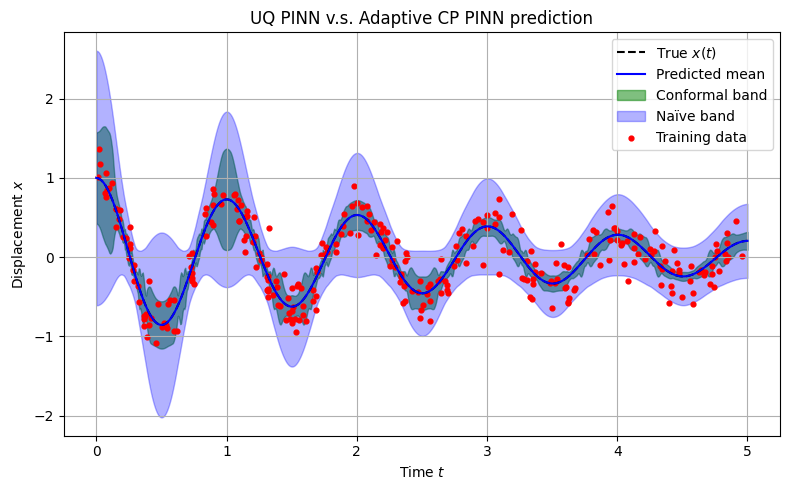

In [22]:
from utils_tools.utils_result_viz import plot_1d_intervals_comparison
plot_1d_intervals_comparison(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution,            # pass the function
    t_train=X_train,
    y_train=Y_train,
    title="UQ PINN v.s. Adaptive CP PINN prediction"
)

In [23]:
# Normal CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":20
}
from utils_uqmd.utils_uq_cp import CP
cp_model = CP(uqmodel)
cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=grid_test,
            **cp_pred_kwargs
        )

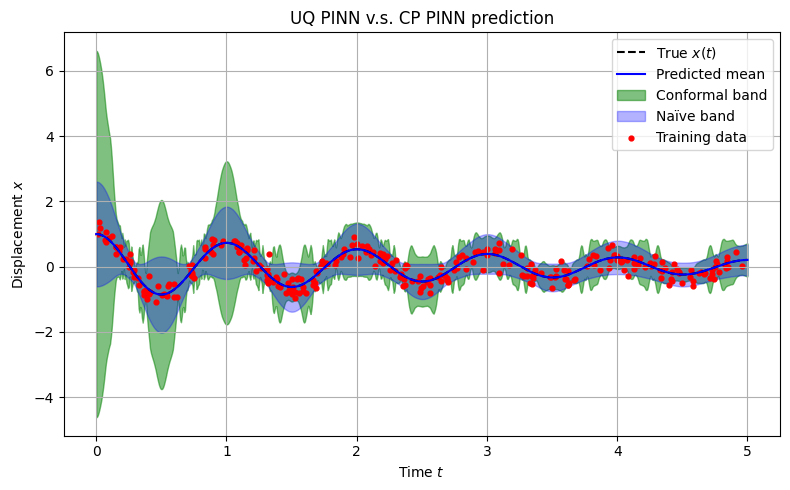

In [24]:
plot_1d_intervals_comparison(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution,            # pass the function
    t_train=X_train,
    y_train=Y_train,
    title="UQ PINN v.s. CP PINN prediction"
)

In [25]:
# CP Coverage comparison
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas()


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":10
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":10
}
cp_df = cp_test_uncertainties(**cp_testing_args)
adap_df = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:  16%|█▌        | 3/19 [00:00<00:00, 21.96it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid:  47%|████▋     | 9/19 [00:00<00:00, 23.84it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid:  79%|███████▉  | 15/19 [00:00<00:00, 24.30it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid: 100%|██████████| 19/19 [00:00<00:00, 24.00it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


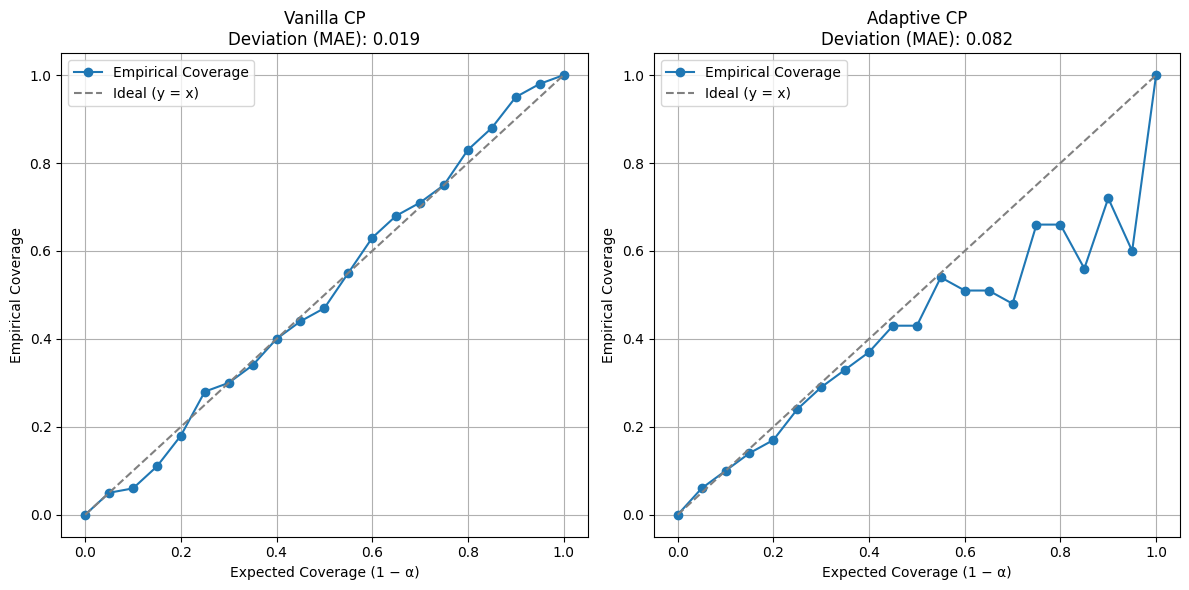

In [26]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(cp_df, adap_df, title1="Vanilla CP", title2="Adaptive CP")

In [27]:
cp_df

,alpha,coverage,sharpness,sdcv,interval score
0,0.05,0.98,1.770943,0.949911,1.806455
1,0.10,0.95,1.347486,0.949911,1.420586
2,0.15,0.88,0.985722,0.949911,1.124698
3,0.20,0.83,0.824116,0.949911,0.977365
4,0.25,0.75,0.672809,0.949911,0.859690
5,0.30,0.71,0.592582,0.949911,0.786869
6,0.35,0.68,0.510003,0.949911,0.715687
7,0.40,0.63,0.438468,0.949911,0.652948
8,0.45,0.55,0.373216,0.949911,0.599862
9,0.50,0.47,0.316496,0.949911,0.555600


In [28]:
adap_df

,alpha,coverage,sharpness,sdcv,interval score
0,0.05,0.60,0.430663,0.982238,2.179074
1,0.10,0.72,0.569859,0.967084,1.189180
2,0.15,0.56,0.394320,0.983478,1.038121
3,0.20,0.66,0.481231,0.941045,0.861583
4,0.25,0.66,0.460185,0.924234,0.776398
5,0.30,0.48,0.326313,1.020666,0.723082
6,0.35,0.51,0.378539,1.090703,0.683873
7,0.40,0.51,0.348844,0.952340,0.621175
8,0.45,0.54,0.352758,0.831405,0.577103
9,0.50,0.43,0.276641,0.909654,0.539788


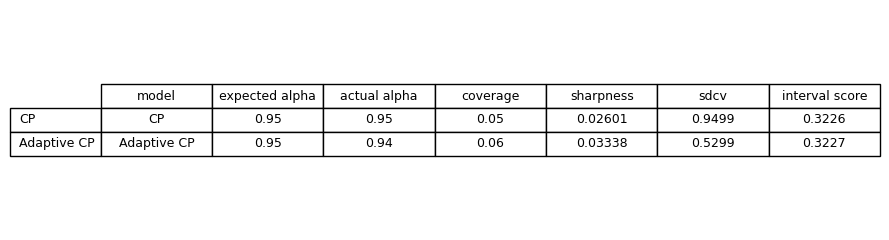

In [29]:
from utils_tools.utils_result_viz import plot_metrics_table
df1=cp_df
df2=adap_df
df1_name="CP"
df2_name="Adaptive CP"
plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.95)